##### Conecta no arcgis

In [20]:
from arcgis.gis import GIS
gis = GIS("home")

/opt/conda/lib/python3.9/site-packages/arcgis/gis/__init__.py:597: UserWarning: You are logged on as Creator_GIS_EER with an administrator role, proceed with caution.
  warnings.warn(


# Atualizacao de Bases atraves de Shapefiles enviados por um formulario no sharepoint


# 01-Entradas

###### Conecta no Sharepoint

########## O login e senha do sharepoint sao segredos pessoais do funcionario , portanto o creator ou qualquer administrador do arcgis nao pode deixar essas informacoes direto no codigo , ja que esse notebook pode ser compartilhado . Dessa forma a solucao e criar um csv privado para o usuario que contem o login senha do usuario. Ao mudar de Creator , nao esquecer de apagar seu login e senha do csv

In [2]:
import csv
SECRET_CSV_ITEM_ID = 'item_id'
def get_secrets(gis=gis,
                secret_csv_item_id=SECRET_CSV_ITEM_ID):
    """Returns the secrets.csv file as a dict of secret_key : secret_value"""
    item = gis.content.get(secret_csv_item_id)
    with open(item.download(), 'r') as local_item_file:
        reader = csv.DictReader(local_item_file)
        return {rows['secret_key']: rows['secret_value'] for rows in reader}
secrets = get_secrets()

#### Ler os arquivos da lista do sharepoint e salva num diretorio local

######## Com seu usuario e senha voce pode acessar a lista  do sharepoint onde esta os pedidos do formulario . Esse codigo baixa o zip extraido depois pega todos os arquivos dentro de subpastas e coloca no diretorio principal , apaga as subpastas e deixa os shps numa pasta temp. Ai ocorrera a leitura de shp posteriormente
E tambem o codigo verifica "Erros crassos de arquivo" por exemplo se o usuario envio um arquivo zipado com todos os arquivos de shapefile dentro e se esses arquivos shapefiles estao com os campos corretos. Muitas vezes campos com acentos ou caracteres comuns em ingles mas nao em pt-br sao lidos erronemeante ficando substituido pelo caracter '?' , que significa 'nao identificado' e causa problema de leitura do shapefile pela library shapefile , dessa forma e necessario que os usuarios mandem shapefiles com campos sem acentos (ou seja shapefiles criados com os moldes que eu preparei previamente).

Tipos de erros:
    Erro1: erros que comprometem o pedido inteiro ( erros de arquivo)
    Erro2: erros que comprometem o pedido parcialmente (erros de linhas de dataframe)

Toda vez que um erro novo for identificado , quando um usuario tiver um comportamento inesperado no envio , e necessario criar uma categoria ou agrega-la aos tipo de erros . Por exemplo , nesse moemnto foi dividio entre erros de arquivo e erros de dataframe . Mas pode haver outros , desta forma mantenha o rastreio de erros atualizado.

In [ ]:
import pandas as pd
from arcgis.geometry import Polygon, Geometry, Point, Polyline

def sdf_from_shp(shapefile_path):
    sdf = pd.DataFrame.spatial.from_featureclass(shapefile_path,encoding='iso-8859-1')
    return sdf

####### Como o kernel e o python constantemente nao conversam ( as vezes o kernel executa antes do python)  eu instalei os pacotes numa pasta chamada library '/arcgis/library' com o comando :pip install --target=/arcgis/library Office365-REST-Python-Client , isso deve resolver o problema dele nao encontrar os pacotes , ja que o kernel constantemente apaga os packges do diretorio de sites

#### Funcoes de offices 365 de leitura da lista do sharpoint

In [ ]:
import sys
sys.path.insert(0, "/arcgis/home/librarys")
from office365.runtime.auth.authentication_context import AuthenticationContext
from office365.runtime.auth.client_credential import ClientCredential
from office365.sharepoint.client_context import ClientContext
from office365.sharepoint.files.file import File

import zipfile
import io 
import tempfile
import shapefile
#pip install Office365-REST-Python-Client

sharepoint_password=secrets["alex.matias@pecenergia.com.br"]
sharepoint_base_url = 'https://empresa.sharepoint.com/sites/Fundiario/'
sharepoint_user = 'alex.matias@pecenergia.com.br'
#autentica no sharepoint e acessa as pastas
auth = AuthenticationContext(sharepoint_base_url) 
auth.acquire_token_for_user(sharepoint_user, sharepoint_password)
ctx = ClientContext(sharepoint_base_url, auth)
web = ctx.web
ctx.load(web)
ctx.execute_query()

In [ ]:
def sharepoint_lists_fundiario(ctx,nome_lista):
        #verifica os itens nao incluidos na base que estao na lista
        """
        itens incluidos tem seu Title modificado para 'Incluido_na_base(editado_power_automate)' quando estao sem erro
        Quando estao com algum Erro de formato nao esperado de anexo , ou seja nao e um arquivo .zip com shapefiles dentro
        nomea-se "Erro1" e "Erro2" para erro nos campos do shapefile
        """
        titulos_esperados=['Incluido_na_base(editado_power_automate)','Erro1','Erro2']
        #Retorna a lista do sharepoint
        sp_site_lists = ctx.web.lists.get_by_title(nome_lista)
        all_items = sp_site_lists.items.paged(1000).get().execute_query()
        list_items = [item for item in all_items if item.properties["Title"] not in titulos_esperados]
        return list_items

In [ ]:

def download_attachments(ctx, list_item):
    # Obter anexos do item da lista
    attachments = list_item.attachment_files.get().execute_query()
    def erro1(list_item):
        list_item.set_property('Title', "Erro1")
        list_item.update()
        ctx.execute_query()
        return('Erro1','Erro1')
    # Verificar se o título do anexo é um arquivo zip com shapefiles dentro
    if len(attachments)==0:
        erro1(list_item)
    else:
        attachment_title = attachments[0].properties["FileName"]
        if not attachment_title.endswith(".zip"):
            erro1(list_item)
        else:
            # Obter informações do item da lista
            projeto = list_item.properties['Projeto']
            operacao = list_item.properties['TipodeOperacaonabase']
            item_id = list_item.properties["Id"]
            creator_id=list_item.properties["AuthorId"]

            if(list_item.properties["Attachments"]):
                # Baixar cada anexo para o diretório correspondente
                for attachment in attachments:
                    file_name = f"{projeto}_{operacao}_{creator_id}_{item_id}.zip"
                    folder_path = f"/arcgis/home/Nao Incluidos/{operacao}"
                    caminho=os.path.join(folder_path, file_name)

                    # Baixa o conteúdo do anexo e o escreve em um arquivo
                    with open(caminho, "wb") as f:
                        content=attachment.download(f).execute_query()
                    print(not(verificar_arquivo_shapefile_zip(caminho)))
                    if(not(verificar_arquivo_shapefile_zip(caminho))):
                        with zipfile.ZipFile(caminho) as zip_ref:    
                            zip_ref.extractall('/arcgis/home/Nao Incluidos/temp')    
                        cria_zip_legivel(folder_path, file_name)
                        print("Download de anexo com sucesso")
                    else : print("nao e arquivo .zip")
                os.remove(os.path.join(folder_path, file_name[:-4]+'.zip'))        
                return (os.path.join(folder_path, file_name[:-4]+'.shp'),operacao)

#### Funcoes que verificam o .zip e colocam os arquivos num formato esperado ( um arquivo zipado com os arquivos .shp dentro)

In [ ]:
import pandas as pd
def cria_zip_legivel(roots, file_name):
    import zipfile
    import os
    import shutil
    # Define o nome do arquivo zip original e do arquivo zip novo
    file_name=file_name[:-4]
    # Percorre as subpastas da pasta extraída e move os arquivos para a pasta principal
    for root, dirs, files in os.walk('/arcgis/home/Nao Incluidos/temp'):
        for file in files:
            if(not(file.endswith('.zip'))):
                os.rename(os.path.join(root, file), os.path.join(root, file_name+file[-4:]))
                shutil.move(os.path.join(root, file_name+file[-4:]), os.path.join(roots, file_name+file[-4:]))
                
    caminho = '/arcgis/home/Nao Incluidos/temp'
    for root, dirs, files in os.walk(caminho):
            for dir in dirs:
                shutil.rmtree(os.path.join(root, dir))
def verificar_arquivo_shapefile_zip(nome_arquivo_zip):
    import zipfile
    # Lista de extensões esperadas
    extensoes_esperadas = ['.shp', '.shx', '.dbf']

    # Dicionário para contar o número de ocorrências de cada extensão
    ocorrencias_extensoes = {extensao: 0 for extensao in extensoes_esperadas}

    # Função para verificar se um nome de arquivo corresponde a uma extensão esperada
    def verificar_extensao(nome_arquivo):
        extensao = nome_arquivo.split('.')[-1].lower()
        return extensao in ocorrencias_extensoes

    # Função para percorrer todas as pastas e subpastas dentro do arquivo zip
    def percorrer_zip(zip, caminho=''):
        for nome_arquivo in zip.namelist():
            if nome_arquivo.startswith(caminho):
                partes_caminho = nome_arquivo.split('/')
                if len(partes_caminho) > len(caminho.split('/')) and partes_caminho[len(caminho.split('/'))] != '':
                    continue
                if '/' in nome_arquivo[len(caminho):]:
                    percorrer_zip(zip, nome_arquivo)
                elif verificar_extensao(nome_arquivo):
                    ocorrencias_extensoes[nome_arquivo.split('.')[-1].lower()] += 1
    # Abrir o arquivo zip
    with zipfile.ZipFile(nome_arquivo_zip, 'r') as zip:
        # Percorrer todas as pastas e subpastas dentro do arquivo zip
        percorrer_zip(zip)

    # Verificar se cada extensão ocorreu apenas uma vez
    for extensao, ocorrencias in ocorrencias_extensoes.items():
        if ocorrencias != 1:
            return False
            print("tudo ok")
    return True

def error_report(arquivo_zip, tipo):
    if(verificar_arquivo_shapefile_zip(arquivo_zip)):
        print("E um arquivo zip")
        return True 
    else:return False

#### Verifica se o .shp esta no formato correto

In [ ]:
# CONSERTAR COM OS MOLDES CORRETOS    
def verifica_campos_shp(shapefile_path,tipo):
    #SO FUNCIONA PRO MOLDE SEM ACENTO
    print(shapefile_path)
    try :
        sdf = sdf_from_shp(shapefile_path)
    except: 
        print("erro no modelo")
        return False
    display(sdf)
    if(tipo=='Inclusao'):
        lista_campos=["Status","Proprieta","Matricula","Contrato","Imovel"]
        colunas=["Status","Proprieta"]
    if(tipo=='Edicao'):
        lista_campos=['area_code']
        colunas=['area_code']
    if(tipo=='Divisao'):
        lista_campos=['area_code',"Status","Proprieta","Matricula","Contrato","Imovel"]
        colunas=["Status","Proprieta"]
    
    if set(lista_campos).issubset(set(sdf.columns)):
        aceito=True
    else:
        aceito=False

    return aceito

In [ ]:
def main():
    print('Conectado ao SharePoint: ',web.properties['Title'])
    items=sharepoint_lists_fundiario(ctx,'Solicitar Modificacao de base')
    exclusoes=pd.DataFrame(columns=["ID_pedido", "Projeto","Exclusao"])
    for item in items:
        if(item.properties["TipodeOperacaonabase"]!='Exclusao'):
            print(item.properties["ID"])
            (caminho,tipo)=download_attachments(ctx,item)
            
            if(not(verifica_campos_shp(caminho,tipo))):
                print("nao aceita")
                item.set_property('Title', "Erro1")
                item.update()
                ctx.execute_query()
                nome_arquivo = os.path.basename(caminho)
                diretorio = os.path.dirname(caminho)
                list_ext=['.dbf','.prj','.shp','.shx','cpg']
                for ext in list_ext:
                    path = os.path.join(diretorio, nome_arquivo[:-4]+ext)
                    if (os.path.exists(path)):
                        os.remove(path)

                print("Arquivo .zip removidos do pedido de operacao na base de ID",item.properties["ID"], "esta incorreto")            


            else: 
                print("Arquivo .zip :",os.path.basename(caminho),"do pedido de operacao na base de ID",item.properties["ID"], "esta correto") 
main()    

# 02-Operacoes do algoritmo

#### Transfroma os shapefiles num conjunto de sdf (spartial dataframe) , depois compara para ver se o sdf intersecta com o conjunto de poligonos de todos os projetos salvando os que foram rejeitados para mandar por email para seus donos 
#### verifica tambem se contem conteudo correto nos campo dos moldes e se esta correto e recusa caso nao esteja

###### Verifica os shps e atualiza a base

### Le os shps , verifica as insterseccoes e retorna os features recusados 

In [3]:
projetos =['mapa1','mapa2'...]

In [4]:
def retorna_posicao(lista,elemento):
    """
    Retorna a posicao de um elemento em uma lista de objetos
    """
    for i in range(len(lista)):
        mapa=str(lista[i])
        split=mapa.replace('"','').replace(' type','').split(':')[1]
        if(split==elemento):
            return i 

#### Funcoes de content manegement do arcgis 

In [5]:
from arcgis.geometry import lengths, areas_and_lengths, project
import pandas as pd
def reproject_sdf(sdf,epsg):
    if(epsg==3857):
        out_SR={'wkid': 102100, 'latestWkid': 3857}
    if(epsg==4326):
        out_SR={'wkid': 4326}
    result = project(
        geometries=list(sdf['SHAPE']),
        in_sr=sdf.spatial.sr,
        out_sr=out_SR
    )

    sdf_reprojetado = pd.DataFrame(columns=sdf.columns)

    for col in list(sdf):
        if col != "SHAPE":
            sdf_reprojetado.loc[:, col] = sdf[col].values

    for i, row in sdf_reprojetado.iterrows():
        sdf_reprojetado.at[i, 'SHAPE']  = result[i]
        
    # Define a coluna "SHAPE" como coluna espacial do DataFrame
    sdf_reprojetado.spatial.set_geometry('SHAPE', inplace=True)
    return sdf_reprojetado


In [6]:
def retorna_df_areas_projetos(projetos):
    dict_layer = {}
    for projeto in projetos:
        map_projeto = gis.content.search('title:' + projeto, 'Feature Layer')
        Projeto_item = map_projeto[retorna_posicao(map_projeto, projeto)]
        Projeto_layers = Projeto_item.layers
        Projeto_tables = Projeto_item.tables
        dict_layer[projeto]={}
        for layer in Projeto_layers:
            lyr_fset = layer.query()
            lyr_sdf = lyr_fset.sdf
            dict_layer[projeto][layer.properties.name]={'sublayer': layer, 'sdf': lyr_sdf}
    return dict_layer


In [7]:
def efetua_exclusoes(sdf,sublayer,operacao_exclusao,dict_layers,Projeto):
    print(operacao_exclusao)
    if(not(operacao_exclusao)):
        sdf_sublayer=dict_layers[Projeto][sublayer]['sdf']
        if not sdf_sublayer.empty:
            lista_area_code = sdf_sublayer['area_code'].unique()
            condicao = sdf['area_code'].isin(lista_area_code)
            display(sdf_sublayer[condicao][['OBJECTID']])
            lista_deletes=[]
            lista_deletes = str(sdf_sublayer[condicao][['OBJECTID']].tolist())
            print(lista_deletes)
            if(lista_deletes!=[]):result=dict_layers[Projeto][sublayer]['sublayer'].edit_features(deletes=lista)
            if(result):
                print("para o sublayer", sublayer,"temos:")
                print("features deletados de area_code",areas_code)
                if(operacao_exclusao):confirma_pedidos(sdf,'Exclusao')
    else : print("nao entro")

In [8]:
#Retorna o dicionario contendo as infos de todos os layers
dict_layers=retorna_df_areas_projetos(projetos)

#### Funcoes de verificacoes

In [ ]:
projetos_GPD =['BRE','CUN','ESV','JAG','MEL','SAL','SAS','SCA','SDJ','SEC','SGA','SGE','SGO','SGW','SIB','SPA','SSE','STE','TDV','VCH','VES']
projetos_novos=['SMA','SSV','STA','SCR','SCB','SOU']

In [ ]:
def atribuir_erro(sdf,erro_tipo,condicao):
    sdf.loc[condicao, 'erro'] = erro_tipo
    return sdf

In [ ]:
import numpy as np
def verifica_campos_vazios(sdf, tipo, filename, dict_layers):
    Projeto = filename.split('_')[0]
    sdf_props = dict_layers[Projeto]['Areas']['sdf']
    ID_pedido = filename.split('_')[3][:-4]
    
    sdf['ID_pedido'] = [ID_pedido] * len(sdf)  # Rastreio do pedido
    sdf["erro"] = np.nan * len(sdf)

    # Verifica erros de geometria
    condicao = ~sdf['SHAPE'].apply(lambda geom: geom.is_valid())
    sdf = atribuir_erro(sdf, 8, condicao)
    
    # Bloco case
    if(tipo=='Edicao'):
        actions = {
        'Edicao': [
                    (3, ~sdf['area_code'].isin(sdf.drop_duplicates(subset=['area_code'], keep=False)['area_code'])),
                    (2, ~sdf['area_code'].isin(sdf_props['area_code'].unique()))
                    ]
                    }
    if(tipo=='Inclusao'):
        actions = {
            'Inclusao': [
                (5,  ~(((sdf['Matricula'].notnull() | sdf['Contrato'].notnull()) & (sdf['Status'] == 'Mapeado com documentos')) | (sdf['Status'] == 'Mapeado sem documentos')) & (sdf['Status'].notnull() & sdf['Proprieta'].notnull()))
                ]
            }
    if tipo in actions:
        for error_code, condition in actions[tipo]:
            sdf = atribuir_erro(sdf, error_code, condition)
    
    # Reprojeta apenas os sdf que não contêm erros
    condicao_erro_nan = sdf['erro'].isna()
    if not sdf[condicao_erro_nan].empty:
        sdf.loc[condicao_erro_nan, 'SHAPE'] = reproject_sdf(sdf[condicao_erro_nan], 3857)['SHAPE']
    
    return sdf



#### Funcoes de atualizacoes nos mapas & sharepoint

In [ ]:
import zipfile
def zipar_arquivos(nome_arquivo_zip,pasta):
    arquivos_zip = [arquivo for arquivo in os.listdir(pasta) if arquivo.startswith("recusada_") and arquivo.endswith((".shp", ".shx", ".prj","dbf"))]
    
    with zipfile.ZipFile(os.path.join(pasta, nome_arquivo_zip), 'w', zipfile.ZIP_DEFLATED) as zipf:
        [zipf.write(os.path.join(pasta, arquivo), os.path.relpath(os.path.join(pasta, arquivo), pasta)) for arquivo in arquivos_zip]
    
    for arquivo in arquivos_zip:
        caminho_completo = os.path.join(pasta, arquivo)
        os.remove(caminho_completo)
    
    return os.path.join(pasta, nome_arquivo_zip)

In [ ]:
def retorna_area(geometria):
    return geometria.area/4046.85642

In [ ]:
import pandas as pd
from arcgis.features import FeatureLayer
from arcgis.geometry.functions import *
from arcgis.geometry import Polygon, Geometry, Point, Polyline
from arcgis.geocoding import geocode
from arcgis.geometry.filters import *

def encontra_sobreposicao(sdf1, sdf2, col1, col2):
    # converter geometrias do SDF em objetos Geometry
    geometries1 = [Geometry(geometry) for geometry in sdf1['SHAPE']]
    geometries2 = [Geometry(geometry) for geometry in sdf2['SHAPE']]
    
    # cria objeto R-tree a partir do segundo SpatialDataFrame
    rtree = sdf2.spatial.sindex('rtree', reset=False)
    # encontra índices das geometrias de sdf2 que se intersectam com sdf1
    intersecting_indexes = set()
    for i, geometry in enumerate(geometries1):
        intersecting_indexes.update(rtree.intersect(geometry.extent))
    
    # converte índices em pares únicos de geometrias que se intersectam
    intersecting_pairs = set()
    for i in intersecting_indexes:
        if i < len(sdf2):
            # a geometria é do segundo sdf
            for j, geometry in enumerate(geometries1):
                try:
                    if Geometry(geometry).intersect(Geometry(sdf2.loc[i, 'SHAPE'])):
                        intersecting_pairs.add((j, i))

                except:
                    print("Para a propriedade OBJECTID", sdf1[col1][j], "foi detectado um erro de topologia na interseção")
                    sdf1.iloc[j, sdf1.columns.get_loc("erro")] = 8
                    

    # criar um dicionário para armazenar as áreas das interseções
    areas_intersect = pd.DataFrame(columns=[col1, "area_acres", col2, "SHAPE"])
    
    # calcular as áreas das interseções e armazená-las no dicionário
    for i, j in intersecting_pairs:
        try:
            intersection = geometries1[i].intersect(geometries2[j])
            
            if not intersection.is_empty and 'rings' in intersection:
                areas_intersect = areas_intersect.append({ 
                                            "area_acres": abs(retorna_area(intersection)),
                                            col1: sdf1[col1][i],
                                            col2: sdf2[col2][j],
                                            "SHAPE": intersection
                                        }, ignore_index=True)
        except Exception as e:
            # Tratar casos de erro de Topologia, ou seja, erros de ordem de pontos (8)
            if 'TopologyException' and 'geom 1' in str(e):
                print("Para a propriedade OBJECTID", sdf1[col1][i], "foi detectado um erro de topologia na interseção")
                sdf1.iloc[i, sdf1.columns.get_loc("erro")] = 8

    areas_intersect.spatial.set_geometry('SHAPE', inplace=True)
    return areas_intersect


In [ ]:
def confirma_pedidos(sdf,tipo_operacao):
    caminho = '/arcgis/home/Nao Incluidos'
    items = sharepoint_lists_fundiario(ctx, 'Solicitar Modificacao de base')
    ID = sdf['ID_pedido'].drop_duplicates().iloc[0]
    for item in items:
        if str(item.properties['ID']) == str(ID):
            if sdf['erro'].notnull().any():
                item.set_property('Title', 'Erro2')
                item.update()
                ctx.execute_query()
                path = os.path.join(caminho, 'temp', 'recusada_' + ID)
                print("EAE")
                colunas_erro=['erro','Proprietario_principal','SHAPE']
                if 'area_acres_intersect' and 'area_code_intersect' in sdf.columns:
                    colunas_erro.append('area_acres_intersect')
                    colunas_erro.append('area_code_intersect')
        
                sdf[~sdf['erro'].isna()][colunas_erro].spatial.to_featureclass(location=path, overwrite=True)
                arquivo_zip = zipar_arquivos(os.path.join(caminho, 'temp',ID + '_' + 'Erro2.zip'),os.path.join(caminho, 'temp'))

                with open(arquivo_zip, 'rb') as fh:
                    file_content = fh.read()
                
                print(arquivo_zip)
                folder_in_sharepoint = '/sites/Fundiario/Erros'
                name = os.path.basename(arquivo_zip)
                target_folder = ctx.web.get_folder_by_server_relative_url(folder_in_sharepoint)
                target_file = target_folder.upload_file(name, file_content).execute_query()
                
                os.remove(arquivo_zip)
            else:
                item.set_property('Title', 'Incluido_na_base(editado_power_automate)')
                item.update()
                ctx.execute_query()

            if tipo_operacao != 'Exclusao':
                for root, dirs, files in os.walk(caminho):
                    for file in files:
                        if ID in file:
                            os.remove(os.path.join(root, file))
                    print("objeto de ID", ID, "apagado")


In [ ]:
def edit_features_sdf(sdf_edits,tipo,layer_projeto,Projeto):
        """
            No caso das edicoes de Interseccoes e areas aprovadas podem ocorrer de ter mais de um caso para cada prop , 
            dessa forma para garantir que as edicoes nao deixem features "a mais" e necessario primeiro apagar e entao adicionar
        """ 
        actions = {
                    'Edicao': {
                        'Areas_Intersect': ('adds', False),
                        'Areas_Aprovadas': ('adds', False),
                        'Areas': ('updates', None)
                    },
                    'Inclusao': {
                        'Areas_Intersect': ('adds', True),
                        'Areas_Aprovadas': ('adds', True),
                        'Areas': ('adds', True)
                    }
                }
        #Agora e necessario adicionar nos mapas e marcar o pedido como aceito ou rejeitado  
    
        sdf_copia=sdf_edits['Areas'].copy()
        sdf_edits['Areas']=sdf_edits['Areas'][sdf_edits['Areas']['erro'].isna()]
        sublayers=['Areas']
        #sublayers=['Areas_Intersect','Areas_Aprovadas','Areas']

        if tipo in actions:
            for sublayer in sublayers:
                if not sdf_edits[sublayer].empty:
                    print(sublayer)
                    #Monta o feature set para adicionar no arcgis
                    fields = [i['name'] for i in layer_projeto[Projeto][sublayer]['sublayer'].properties.fields if i['editable']]
                    if sublayer != 'Areas_Aprovadas':
                        fields.append('SHAPE')
                    if tipo == 'Edicao':
                        fields.append('OBJECTID')
                    edit_fs_df = pd.DataFrame(columns=fields)
                    for col in edit_fs_df.columns:
                        if col in sdf_edits[sublayer]:
                            edit_fs_df[col] = sdf_edits[sublayer][col].values
                    feature_set = edit_fs_df.spatial.to_featureset()
                    display(sdf_edits[sublayer])
                    #aplica as acoes necesserias 
                    action, arg = actions[tipo][sublayer]
                    if action == 'updates':
                        result = layer_projeto[Projeto][sublayer]['sublayer'].edit_features(updates=feature_set)
                    elif action == 'adds':
                        efetua_exclusoes(sdf_edits[sublayer], sublayer, arg, dict_layers, Projeto)
                        result = layer_projeto[Projeto][sublayer]['sublayer'].edit_features(adds=feature_set)

                    print(result)

                    if(result):
                        if(tipo=='Edicao'):print("features editados com sucesso")
                        if(tipo=='Inclusao'):print("features incluidos com sucesso")



In [ ]:
import pandas as pd
def encotra_areas_inutilizadas(frase):
    import re
    padrao = r"PROP-\w{3}-\d{4}"

    ocorrencias = re.findall(padrao, frase)
    return ocorrencias

def faz_exclusoes():
    dict_layers=retorna_df_areas_projetos(projetos)
    items=sharepoint_lists_fundiario(ctx,'Solicitar Modificacao de base')
    exclusoes=pd.DataFrame(columns=["ID_pedido", "Projeto","Exclusao"])
    for item in items:
        if(item.properties["TipodeOperacaonabase"]=='Exclusao'):
            if(item.properties["Areaaserexcluida"] is not None):
                try:
                    for exclusao in encotra_areas_inutilizadas(item.properties["Areaaserexcluida"]):
                        exclusoes=exclusoes.append({ 
                                        "ID_pedido": item.properties["Id"],
                                        "Projeto":item.properties['Projeto'],
                                        "area_code":exclusao
                                    }, ignore_index=True)
                except:
                    item.set_property('Title', "Erro1")
                    item.update()
                    ctx.execute_query()
                exclusoes['TipodeOperacaonabase']=[item.properties["TipodeOperacaonabase"]] * len(exclusoes)
    if not exclusoes.empty:                                                      
        efetua_exclusoes(exclusoes,'Areas',True,dict_layers)  

In [ ]:
from arcgis import GIS
import pandas as pd
import zipfile
from arcgis.geometry import Polygon, Geometry, Point, Polyline

import numpy as np

def retorna_novo_codigo_GPD(Projeto,sdf):
    #### insere os numeros das props quando e INCLUSAO
    lista_area_code = dict_layers[Projeto]['Areas']['sdf']['area_code'].unique()
    maximo = int(max(lista_area_code, key=lambda x: int(x.split('-')[-1])).split('-')[2])
    
    if lista_area_code is []: sdf['area_code'] = '0'
    
    # gerar uma sequência de novos números
    n_novos_itens = len(sdf)
    novos_numeros = range(maximo+1, maximo+1+n_novos_itens)

    # atribuir os novos números à coluna area_code
    df_novos = pd.DataFrame({'area_code': [f'PROP-{str(Projeto).zfill(3)}-{str(n).zfill(4)}' for n in novos_numeros]})

    #atribui as colunas que nao tao no padrao
    sdf['area_code'] = df_novos['area_code'].values
    
    return sdf

def verifica_intersect(sdf,filename,dict_layers):
    
    #Inicia as variaveis necessarias para rastreio
    ID_pedido=filename.split('_')[3][:-4]
    ID_author=filename.split('_')[2]
    Projeto=filename.split('_')[0]
    TipodeOperacaonabase=filename.split('_')[1]
    
    #Variaveis do pedido
    sdf['Projeto']=[Projeto]*len(sdf)
    sdf['TipodeOperacaonabase']=[TipodeOperacaonabase]* len(sdf)
    
    print("inicio")
    display(sdf)
    #sdf de analises das props
    areas=dict_layers[Projeto]['Areas']['sdf']
    areas_filtradas = areas[areas['area_code'].str.contains(Projeto)]
    
    if(TipodeOperacaonabase=='Inclusao'):
        sdf=sdf.rename(columns={'Proprieta': 'Proprietario_principal'})
    # Um sdf do tipo edicao nao tem as infos dentro do poligono enquanto a inclusao nao tem area_code
    if(TipodeOperacaonabase=='Edicao'):
        #para a edicao conter todos os campos e capturar o OBJECT ID conrrespondente
        if 'OBJECTID' in sdf.columns:sdf = sdf.drop('OBJECTID', axis=1)
        sdf = pd.merge(sdf, areas[['area_code','OBJECTID','Status',"Proprietario_principal",'Contrato',"Matricula"]], on='area_code')
        #eliminando as areas com o mesmo area_code da area a ser editada no projeto , eliminando area de interseccao com ela mesma
        area_codes = sdf['area_code'].unique()
        mask = areas_filtradas['area_code'].isin(area_codes)
        areas_filtradas.drop(areas_filtradas[mask].index, inplace=True)
    
    #renomeando para nao haver campo "area_code" duplicados
    areas_filtradas=areas_filtradas.rename(columns={'area_code': 'area_code_intersect'})
    sdf_sem_erros=sdf[sdf['erro'].isna()]
    sdf_sem_erros.spatial.set_geometry('SHAPE', inplace=True)
    sdf_intersect_props=encontra_sobreposicao(sdf_sem_erros, areas_filtradas,'OBJECTID','area_code_intersect')
    sdf_intersect_props=sdf_intersect_props.rename(columns={'area_acres': 'area_acres_intersect'})

    if not(sdf_intersect_props.empty):
        #Aplica a condicao de aceitacao e recusa do poligono onde se houver mais de 2(ha) de interseccao a area sera recusada e enviada para revisao (7)
        merge_condition=sdf_intersect_props['area_acres_intersect']>2
        aggregated_df = sdf_intersect_props[merge_condition].drop_duplicates(subset='OBJECTID')
        sdf = sdf.merge(aggregated_df[['area_acres_intersect','area_code_intersect','OBJECTID']], on='OBJECTID', how='left')
        display(sdf)
        condicao = sdf['area_acres_intersect'] > 2
        sdf = atribuir_erro(sdf, 7, condicao)

    #Dicionario que contem os edits do sublayer , ira-se adicionar apenas os que nao contem erros 
    sdf_operacoes_mapas={'Areas':sdf,'Areas_Intersect': sdf_intersect_props, 'Areas_Aprovadas': pd.DataFrame()}    
    
    if sdf[sdf['erro'].isna()].empty:
        print("O SpatialDataFrame está vazio ,todas as props foram recusadas devido a interseccoes maiores que 2(ha) para o id",ID_pedido)
    else:
        #Agora verifica se a area intersecta buffers de linhas de aeros ou poligonos de paineis solares 
        print("O DataFrame não está vazio.")
        
        if(TipodeOperacaonabase=='Edicao'):
            sdf['ID_Editor']=[ID_author]* len(sdf)
        if(TipodeOperacaonabase=='Inclusao'):    
            sdf['ID_Creator']=[ID_author]* len(sdf)
            sdf.loc[sdf['erro'].isna(),'area_code']=retorna_novo_codigo_GPD(Projeto,sdf[sdf['erro'].isna()])
            sdf_intersect_props=sdf_intersect_props.merge(sdf[['OBJECTID', 'area_code']], on='OBJECTID', how='left')
            sdf_intersect_props = sdf_intersect_props.drop('OBJECTID', axis=1)
            sdf = sdf.drop('OBJECTID', axis=1)
        inicio=True
        if Projeto in projetos_GPD:
            for buffer in ['Linhas_EOL', 'Linhas_UFV']:
                linhas_aeros = dict_layers[Projeto][buffer]['sdf']
                if not linhas_aeros.empty:
                    linhas_filtradas = linhas_aeros[linhas_aeros['linha_code'].str.contains(Projeto)]
                    
                    sdf_sem_erros = sdf[sdf['erro'].isna()]
                    sdf_sem_erros.spatial.set_geometry('SHAPE', inplace=True)
                    sdf_linha_props = encontra_sobreposicao(sdf_sem_erros, linhas_filtradas, 'area_code', 'linha_code')
                    if(inicio):
                        sdf_linhas=sdf_linha_props
                        inicio=False
                    else:
                        if not (sdf_linha_props.empty):
                            sdf_linhas = pd.concat([sdf_linha_props, sdf_linhas], ignore_index=True)
            
            sdf['Status_Aprovacao'] = ["Parcialmente Aprovado"] * len(sdf)
            if(inicio):
                #sdf.loc[sdf['area_code'].isin(sdf_linhas['area_code']), 'linha_code'] = sdf_linha_props['linha_code']
                sdf.loc[sdf['area_code'].isin(sdf_linhas['area_code']), 'Status_Aprovacao'] = 'Aprovado'
                sdf_operacoes_mapas['Areas_Aprovadas'] = sdf_linhas
                sdf_operacoes_mapas['Areas'] = sdf

                print("fim")
        
    print("sdf do pedido")
    display(sdf_operacoes_mapas['Areas'])        
    #Adiciona o sdf e muda o status do pedido pra Aceito 
    edit_features_sdf(sdf_operacoes_mapas,TipodeOperacaonabase,dict_layers,Projeto)

    return sdf
               

#### Executa o processo de verificacoes dos shps e atualizacoes nos mapas

In [ ]:
def separar_por_props_novas(sdf):
    sdf_com_objectid = sdf[sdf['TipodeOperacaonabase']=='Edicao']
    sdf_sem_objectid = sdf[sdf['TipodeOperacaonabase']=='Inclusao']
    return sdf_com_objectid, sdf_sem_objectid

def main():
    caminho='/arcgis/home/Nao Incluidos'
    inicio=True
    
    # percorre o diretório e realiza as operações necessárias
    for root, dirs, files in os.walk(caminho):
        for diretorio in dirs:
            if(diretorio in ['Inclusao','Edicao','Divisao']):
                print("No diretório: ", diretorio)
                diretorio_atual = os.path.join(root, diretorio)
                for file in os.listdir(diretorio_atual):
                    if file.endswith(".shp"):
                        path=os.path.join(root,diretorio_atual,file)
                        print("Coletando info geograficas do .shp", path)
                        sdf=verifica_campos_vazios(sdf_from_shp(path),diretorio,file,dict_layers)
                        sdf=verifica_intersect(sdf,file,dict_layers)
                        confirma_pedidos(sdf,diretorio_atual)
                        if(inicio):
                            sdf_pedidos=sdf
                            inicio=False
                        else:
                            sdf_pedidos = pd.concat([sdf, sdf_pedidos], ignore_index=True)
                                                              
    if not sdf_pedidos.empty:
        print("Informacoes coletadas")
        sdf_pedidos.rename(columns={'Proprieta': 'Proprietario_principal'}, inplace=True)
        print("Os pedidos aceitos foram:")
        display(sdf_pedidos)
        #sdf_adds=separar_por_props_novas(sdf_pedidos)
        colunas=['Projeto','area_code','Proprietario_principal','Imovel','Status','Matricula','Contrato']
        if(sdf_pedidos['area_code_intersect'].notna().any()):colunas.append('Areas_Intersect')
        #if('linha_code' in sdf_pedidos.columns):colunas.append('Status_Aprovacao')
        sdf_pedidos[sdf_pedidos['TipodeOperacaonabase']=='Inclusao'].to_excel('/arcgis/home/modificacoes na base.xlsx', index=False)
        print("Os pedidos recusados foram:")
        display(sdf_pedidos.loc[~sdf_pedidos['erro'].isna()])
    else:
        print("So ha pedidos recusados")
        display(sdf_pedidos.loc[~sdf_pedidos['erro'].isna()])

faz_exclusoes()
main()

# 03-Saidas

### Captura as inclusoes recentes e insre numa planilha com uma macro que insere nas planilhas GPD

In [ ]:
import datetime
import pandas as pd

def retorna_projeto_data(titulo_projeto,mes,dia,ano):
    map_projeto = gis.content.search('title:'+titulo_projeto,'Feature Layer')
    mapa = map_projeto[retorna_posicao(map_projeto,titulo_projeto)]
    Projeto_layers= mapa.layers
    for lyr in Projeto_layers:
            if(lyr.properties.name == 'Areas'):
                    layer=lyr
    data_alvo = datetime.date(ano, mes, dia) # define a data de referência
    #ex:data_alvo = datetime.date(2023, 3, 12)
    data_alvo_str = data_alvo.isoformat() # converte para uma string no formato 'AAAA-MM-DD'
    filtro_data = f"CreationDate >= TIMESTAMP '{data_alvo_str}'"
    resultados = layer.query(where=filtro_data)
    areas=resultados.sdf
    return areas
def captura_inclusoes_hoje():
    # Obter a data atual
    data_atual = datetime.date.today()

    # Obter o dia
    dia = data_atual.day
    #dia=8

    # Obter o mês
    mes = data_atual.month
    #mes=6

    inicio=True
    for projeto in projetos:
        sdf=retorna_projeto_data(projeto,mes,dia,2023)
        if not sdf.empty:
            print("Ha itens novos para o projeto",projeto)
            sdf['Projeto']=[projeto]*len(sdf)
            if(inicio):
                sdf_pedidos=sdf
                inicio=False
            else:
                sdf_pedidos=pd.concat([sdf_pedidos, sdf], ignore_index=True)

    heading_meses=[]

    colunas=['Projeto','area_code','Proprietario_principal','Imovel','Status','Matricula','Contrato']
    df=sdf_pedidos[colunas]

    df = df.rename(columns={'Proprietario_principal': 'Proprietário principal'})
    df = df.rename(columns={'area_code': 'AREA_CODE'})
    df = df.rename(columns={'Imovel': 'Imóvel'})
    df['mes']=len(df)*[heading_meses[mes-1]]

    return df

In [ ]:
dataset = '/arcgis/home/excel.xlsm'

In [ ]:
import openpyxl

arquivo_adds=dataset

def salva_adds_excel():
    df=captura_inclusoes_hoje()
    # Carregar o arquivo Excel existente
    workbook = openpyxl.load_workbook(arquivo_adds,keep_vba=True)

    # Selecionar a planilha "Indice"
    sheet = workbook['Indice']

    # Criar um dicionário para mapear o nome da coluna para o número da coluna na planilha "Indice"
    column_dict = {}
    for column in sheet.iter_cols(min_row=1, max_row=1):
        for cell in column:
            column_dict[cell.value] = cell.column

    # Adicionar uma coluna com os índices do DataFrame original
    df['Indice'] = df.index

    # Agrupar as linhas por projeto no dataframe
    agrupado = df.groupby('Projeto')

    # Apagar os valores da coluna "Importado fundiário"
    for row in sheet.iter_rows(min_row=2, min_col=column_dict['Importado fundiário'], max_col=10):
        row[0].value = None

    for row in sheet.iter_rows(min_row=2, min_col=column_dict['Linha inicial'], max_col=10):
        row[0].value = None

    for row in sheet.iter_rows(min_row=2, min_col=column_dict['Linha final'], max_col=10):
        row[0].value = None    

    # Percorrer os grupos de projetos
    for projeto, grupo in agrupado:
        # Localizar a linha correspondente na coluna "Projeto" da planilha "Indice"
        for row in sheet.iter_rows(min_row=2, max_col=column_dict['Projeto'], max_row=sheet.max_row):
            if row[0].value == projeto:
                # Obter a primeira e última linha do grupo no dataframe original
                linha_inicial = grupo['Indice'].iloc[0] + 2  # Adiciona 2 para considerar o cabeçalho e a indexação baseada em 1 do Excel
                linha_final = grupo['Indice'].iloc[-1] + 2

                # Atualizar as colunas "Linha inicial" e "Linha final" na planilha "Indice"
                sheet.cell(row=row[0].row, column=column_dict['Linha inicial']).value = linha_inicial
                sheet.cell(row=row[0].row, column=column_dict['Linha final']).value = linha_final

                # Atualizar a coluna "Importado" com "Ok"
                sheet.cell(row=row[0].row, column=column_dict['Importado fundiário']).value = 'Ok'

                break


    ws = workbook['CSV']

    # Limpar a aba "CSV" antes de inserir os novos valores
    ws.delete_rows(2, ws.max_row)

    # Criar um dicionário para mapear o nome da coluna para o número da coluna na planilha "Indice"
    column_dict = {}
    for column in ws.iter_cols(min_row=1, max_row=1):
        for cell in column:
            column_dict[cell.value] = cell.column

    # Inserir os valores na aba "CSV"
    for r_idx, row in enumerate(df.values, 2):
        for col_name, value in zip(df.columns, row):
            if col_name in column_dict:
                col_idx = column_dict[col_name]
                ws.cell(row=r_idx, column=col_idx, value=value)



    # Salvar as alterações no arquivo Excel
    workbook.save(arquivo_adds)

In [ ]:
salva_adds_excel()

### Fluxo Responsavel por detectar titulos de Erro e enviar para o Criador da Solicitacao:

 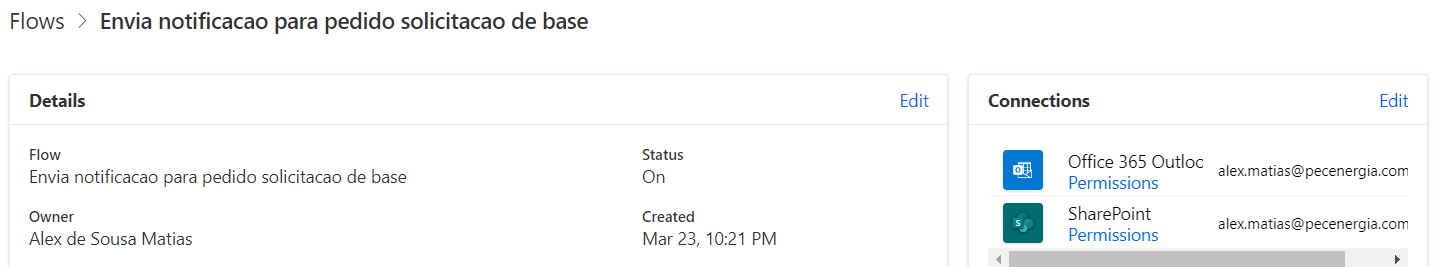

In [ ]:
from arcgis.geometry.functions import *
from arcgis.geometry import Polygon, Geometry, Point, Polyline
from arcgis.geocoding import geocode
from arcgis.geometry.filters import *
import pandas as pd

def retorna_interseccao(area,linhas_aeros):
    #retorna se a area esta aprovada ou nao , ou seja, se ela esta parcialmento dentro de uma linha de aero ou nao
    for feature_linha_aero in linhas_aeros:
        if Polygon(feature_linha_aero.geometry).intersect(Polygon(area.geometry)).is_empty==False:
            return 'Aprovado'
    return 'Aguardando Aprovacao'

def retorna_num_aeros(area,aeros):
    #retorna o numero de aeros numa area
    num_aeros=0
    for feature_aero in aeros:
        if (Polygon(area.geometry).contains(Point(feature_aero.geometry))):
            num_aeros+=1
    return num_aeros
def retorna_posicao(lista,elemento):
        """
        Retorna a posicao de um elemento em uma lista de objetos
        """
        for i in range(len(lista)):
            mapa=str(lista[i])
            split=mapa.replace('"','').replace(' type','').split(':')[1]
            if(split==elemento):
                return i
            
def le_info_sist_fundiario(titulo_mapa,result):
        """
        Essa funcao le as informacoes para o sistema fundiario de um mapa
        """

        #acessa o mapa do projeto
        map_projeto = gis.content.search('title:'+titulo_mapa,'Feature Layer')
        Projeto_item = map_projeto[retorna_posicao(map_projeto,titulo_mapa)]
        Projeto_layers= Projeto_item.layers
        projeto=titulo_mapa
        for layer in Projeto_layers:
            if(layer.properties.name == 'Aeros'):
                    layer_fset = layer.query()
                
        #captura os features de cada layer
        for layer in Projeto_layers:
                
            if(layer.properties.name == 'Linhas_EOL'):
                layer_fset = layer.query()
                all_features_linha_aeros= layer_fset.features
            if(layer.properties.name == 'Areas'):
                layer_fset = layer.query()
                all_features_areas= layer_fset.features
                
        titulo_mapa='Molde_Projeto_GPD'        
        #acessa o mapa do projeto
        map_projeto = gis.content.search('title:'+titulo_mapa,'Feature Layer')
        Projeto_item = map_projeto[retorna_posicao(map_projeto,titulo_mapa)]
        Projeto_layers= Projeto_item.layers
        
        for layer in Projeto_layers:
            if(layer.properties.name == 'Aeros'):
                    layer_fset = layer.query()
                    all_features_aeros= layer_fset.features
                    
        #baseado nas informacoes dos features, cria um dicionario com as informacoes que serao usadas para gerar o kml do sistema fundiario
        for feature_area in all_features_areas:
            area_code = feature_area.attributes['area_code']
            num_aeros = retorna_num_aeros(feature_area,all_features_aeros)
            try:
                aprovacao = retorna_interseccao(feature_area,all_features_linha_aeros)
            except:
                print(area_code,"Esta incorreta")
                aprovacao=''
            if(aprovacao!=''):
                geometria = feature_area.geometry
                result['area_code'].append(area_code)
                result['num_aeros'].append(num_aeros)
                result['aprovacao'].append(aprovacao)
                result['geometria'].append(geometria)
                result['projeto'].append(projeto)

        return result
def cria_df_sist_fundiario(projeto,result):
    dados=le_info_sist_fundiario(projeto,result)
    df=pd.DataFrame.from_dict(dados)
    df = df.rename(columns={'aprovacao': 'status', 'geometria': 'SHAPE'})
    df.spatial.set_geometry('SHAPE', inplace=True)
    display(df)
    
    return df
def main():
    Projetos=['JAG','MEL','VCH','SCA','BRE']
    for projeto in Projetos:
            info_sist_fundiario={'area_code':[],'num_aeros': [], 'aprovacao': [],'geometria': [],'projeto':[]}
            info_sist_fundiario=cria_df_sist_fundiario(projeto,info_sist_fundiario)
            info_sist_fundiario=reproject_sdf(info_sist_fundiario,4326)
            path=os.path.join('/arcgis/home/BASES',projeto+'.shp')
            print(path)
            info_sist_fundiario.spatial.to_featureclass(location=path , overwrite=True);
    #info_sist_fundiario.to_excel('/arcgis/home/sist_fund.xlsx', index=False)

## Gera os .shp e os kmls atualizados para o sist. fundiario

##### Cria um shapefile

In [ ]:
#Retorna o dicionario contendo as infos de todos os layers
dict_layers=retorna_df_areas_projetos(projetos)

In [11]:
project_name={
    'ESV': ['Serra das Vacas','ESV - EOL Serra das Vacas (Fase 3)'],
    'SAL': ['Serra das Almas','SAL - EOL Serra das Almas'],
    'SAS': ['Serra do Assuruá','SAS - EOL Serra do Assuruá'],
    'SGA': ['Serra da Gameleira','SGA - EOL Serra da Gameleira'],
    'SIB': ['Serra de Ibiapaba','SIB - EOL Serra de Ibiapaba'],
    'SPA': ['Serra da Palmeira','SPA - EOL Serra da Palmeira'],
    'SSE': ['Serra do Seridó','SSE - EOL Serra do Seridó'],
    'SGO': ['Gouveia','SGO - EOL Gouveia'],
    'SGW': ['Serra Geral do Oeste','SGW - EOL Serra Geral do Oeste'],
    'BRE': ['Bom Retiro','BRE - EOL Bom Retiro'],
    'CUN': ['Curral Novo','CUN - EOL Curral Novo'],
    'JAG': ['Jaguarari','JAG - EOL Jaguarari'],
    'MEL': ['Meia Lua','MEL - EOL Meia Lua'],
    'SGE': ['Serra de Gentio do Ouro','SGE - EOL Serra de Gentio do Ouro'],
    'SEC': ['Serra da Carneira','SEC - EOL Serra da Carneira'],
    'SDJ': ['Serra Dom João','SDJ - EOL Serra Dom João'],
    'STE': ['Serra de Teixeira','STE - EOL Serra do Teixeira'],
    'SDA': ['Serra do Alegre','SDA - EOL Serra do Alegre'],
    'SCA': ['Serra de Catolé','SCA - EOL Serra do Catolé'],
    'TDV': ['Terra dos Ventos','TDV - EOL Terra dos Ventos'],
    'VES': ['Ventos de Simões','VES - EOL Ventos de Simões'],
    'VCH': ['Ventos de Velho Chico','VCH - EOL Velho Chico'],
    'SMA': ['Serra dos Mares','SMA - EOL Serra dos Mares'],
    'SCR': ['Serra do Croata','SCR - EOL Serra de Croatá'],
    'STA': ['Serra da Taquara','STA - EOL Serra da Taquara'],
    'SSV': ['Serra do Sao Vicente','SSV - EOL Serra do Sao Vicente'],
    'SIF': ['Sistema Fundiario','SIF - EOL Sistema Fundiario']}

### Cria o kmz

In [ ]:
#Retorna o dicionario contendo as infos de todos os layers
dict_layers=retorna_df_areas_projetos(projetos)

In [ ]:
project_name={
    'ESV': ['Serra das Vacas','ESV - EOL Serra das Vacas (Fase 3)'],
    'SAL': ['Serra das Almas','SAL - EOL Serra das Almas'],
    'SAS': ['Serra do Assuruá','SAS - EOL Serra do Assuruá'],
    'SGA': ['Serra da Gameleira','SGA - EOL Serra da Gameleira'],
    'SIB': ['Serra de Ibiapaba','SIB - EOL Serra de Ibiapaba'],
    'SPA': ['Serra da Palmeira','SPA - EOL Serra da Palmeira'],
    'SSE': ['Serra do Seridó','SSE - EOL Serra do Seridó'],
    'SGO': ['Gouveia','SGO - EOL Gouveia'],
    'SGW': ['Serra Geral do Oeste','SGW - EOL Serra Geral do Oeste'],
    'BRE': ['Bom Retiro','BRE - EOL Bom Retiro'],
    'CUN': ['Curral Novo','CUN - EOL Curral Novo'],
    'JAG': ['Jaguarari','JAG - EOL Jaguarari'],
    'MEL': ['Meia Lua','MEL - EOL Meia Lua'],
    'SGE': ['Serra de Gentio do Ouro','SGE - EOL Serra de Gentio do Ouro'],
    'SEC': ['Serra da Carneira','SEC - EOL Serra da Carneira'],
    'SDJ': ['Serra Dom João','SDJ - EOL Serra Dom João'],
    'STE': ['Serra de Teixeira','STE - EOL Serra do Teixeira'],
    'SDA': ['Serra do Alegre','SDA - EOL Serra do Alegre'],
    'SCA': ['Serra de Catolé','SCA - EOL Serra do Catolé'],
    'TDV': ['Terra dos Ventos','TDV - EOL Terra dos Ventos'],
    'VES': ['Ventos de Simões','VES - EOL Ventos de Simões'],
    'VCH': ['Ventos de Velho Chico','VCH - EOL Velho Chico'],
    'SMA': ['Serra dos Mares','SMA - EOL Serra dos Mares'],
    'SCR': ['Serra do Croata','SCR - EOL Serra de Croatá'],
    'STA': ['Serra da Taquara','STA - EOL Serra da Taquara'],
    'SSV': ['Serra do Sao Vicente','SSV - EOL Serra do Sao Vicente'],
    'SIF': ['Sistema Fundiario','SIF - EOL Sistema Fundiario']}

In [ ]:
import time
import json
from arcgis.features import GeoAccessor
nb_id='8db8ce6f647245dcbe09feb8d143d98e'
nb_server = gis.notebook_server[0]
notebook_item = gis.content.get(nb_id)
notebookParameters = {
"project_name": project_name,
"tipo": 'Status Parcial',
"json_areas":areas.to_json(orient='records'),
"projetos":projetos
}
nb_mgr = nb_server.notebooks
nb_result = nb_mgr.execute_notebook(notebook_item,update_portal_item=True,parameters=notebookParameters,save_parameters=False)
print(nb_result)

In [ ]:
from arcgis.gis.nb import NotebookManager
for projeto in projetos:
    areas=dict_layers[projeto]['Areas']['sdf']
    areas=reproject_sdf(areas,4326)
    path=os.path.join('/arcgis/home/BASES',projeto+'.shp')
    areas = areas.reindex(columns=['area_code'] + [col for col in areas.columns if col != 'area_code'])
    areas['Matricula'] = areas['Matricula'].fillna('')  # Preencher valores ausentes com uma string vazia
    areas['Contrato'] = areas['Contrato'].fillna('')
    areas['Status']= areas['Status'].fillna('')
    areas_shp=areas[['area_code','Proprietario_principal','Imovel','Status','Matricula','ID_Creator','ID_Editor','Contrato',"SHAPE"]]
    areas_shp.spatial.to_featureclass(location=path , overwrite=True);
    print(path)

##### Codigo que gera o kmz 

######## funcionarios da topografia ainda necessitam dos shapefiles , portanto e necessario gerar os shapefiles atualizados dos projetos

#### Insere os shp , kmz e modificacoes nas pastas  do sharepoint

#######Atualmente ainda sera usado os planilhas GPD , portanto e necessario atualiza-las. Por isso o codigo cria o arquivo 'modificacoes na base.xlsx' na Bases Cartograficas esse arquivo sera lido por outro processo e ira inserir as modificacoes nas planilhas GPD correspondentes. Tambem e necessario os arquivos shapefiles que terao uploads na pasta do sharepoint. E por ultimo e necessario sinalizar para o formulario que as bases foram incluidas no mapa . Isso e feito atraves do upload dos arquivos zip com os ids do pedido na pasta 'Incluidos' que sinaliza pro powerautomate a conclusao de solicitacao. 

In [ ]:
from office365.sharepoint.client_context import ClientContext
from office365.sharepoint.lists.list import List
import os
import time
sharepoint_user = 'alex.matias@pecenergia.com.br'
sharepoint_password=secrets["alex.matias@pecenergia.com.br"]
sharepoint_base_url = 'https://sites/Fundiario/'
# Autenticar e obter a referência da lista de documentos
ctx = ClientContext(sharepoint_base_url).with_user_credentials(sharepoint_user, sharepoint_password)

def upload_file(file_path, file_name, tipo):
    if(tipo=='Mod_GPD'):folder_in_sharepoint='/sites/Fundiario/Bases%20Cartogrficas/Modificacoes na base'
    elif(tipo=='Bases_kmz_atualizadas'):folder_in_sharepoint='/sites/GPD/FundirioComercial/'+project_name[file_name.split('.')[0].upper()][1]
    elif(tipo=='BASES'):folder_in_sharepoint='/sites/GPD/FundirioComercial/'+project_name[file_name.split('.')[0].upper()][1]
    else:folder_in_sharepoint = '/sites/Fundiario/Bases%20Cartogrficas/00 -Historico de Alteracoes - Base Arcgis/Incluidos/'+tipo
    # Ler o conteúdo do arquivo em um objeto bytes
    with open(os.path.join(file_path,file_name), 'rb') as f:
        file_content = f.read()

    target_folder = ctx.web.get_folder_by_server_relative_url(folder_in_sharepoint)
    name = os.path.basename(file_name)
    if(tipo=='Mod_GPD'):name = os.path.basename(time.strftime("%y_%m_%d")+'_'+file_name)
    target_file = target_folder.upload_file(name, file_content).execute_query()
    print("File has been uploaded to url: {0}".format(target_file.serverRelativeUrl))
    
def delete_file(file_path, file_name, tipo):
    if(tipo=='BASES'):folder_in_sharepoint='/sites/'+project_name[file_name.split('.')[0].upper()][1]
    else:folder_in_sharepoint = '/sites/Nao Incluidos/'+tipo+'/'
    # Ler o conteúdo do arquivo em um objeto bytes
    file_to_delete = ctx.web.get_folder_by_server_relative_url(folder_in_sharepoint+file_name)    
    file_to_delete.delete_object()
    ctx.execute_query()
    print("File has been deleted to url: {0}".format(file_to_delete.serverRelativeUrl))

def main():
    caminho = '/arcgis/home'
    for root, dirs, files in os.walk(caminho):
        for file in files:
            if('BASES'in root or 'Nao Incluidos'in root or file=='modificacoes na base.xlsm' or 'Bases_kmz_atualizadas' in root):
                tipo=''
                if(file=='modificacoes na base.xlsm'):tipo='Mod_GPD'
                elif('Bases_kmz_atualizadas'in root):tipo='Bases_kmz_atualizadas'
                elif('BASES' in root):tipo='BASES'
                elif('Edicoes' in root ):tipo='Edicoes'
                elif('Inclusoes'in root):tipo='Inclusoes'
                elif('Edicoes' in root):tipo='Edicoes'
                elif('Divisoes'in root):tipo='Divisoes'    
                if(tipo!=''):
                    print(file)
                    upload_file(root,file, tipo)
                    if('BASES' not in root and file!='excel.xlsm' ):delete_file(root, file, tipo)
                    if(file!='excel.xlsm'):os.remove(os.path.join(root, file))
main()